<style type="text/css">
    .align-center {text-align: center; margin: auto;}
    h1 {
      color: #D41212;
      font-family: Impact;
      font-weight: bold;
      font-size: 280%;
      text-align: center;
      text-transform: uppercase;
    }
    h2 {
      color: #11A6D9;
      font-family: Tahoma;
      font-size: 230%;
    }
    h3 {
      color: #14D65F;
      font-family: Verdana;
      font-size: 160%;
      margin-left: 1.5em;
    }
    h4 {
      color: #FBC623;
      font-family: Verdana;
      font-size: 160%;
      margin-left: 3em;
    }
</style>
<body style = "text-align:justify">

<div class="align-center">
  <img src="https://minas.medellin.unal.edu.co/images/Escudo_color.png" title="UNAL" alt="UNAL" width="400">
</div>

<h1> &#9989&#128200 BANDAS DE CONFIANZA PARA SERIES DE TIEMPO UTILIZANDO REDES NEURONALES &#128201&#9203 </h1>

<center>
  <img src = "https://imgs.xkcd.com/comics/confidence_interval.png"
       alt    = "Confidence Interval."
       height = "380"
       title  = "Confidence Interval.">
</center>

___
___

#### Autor

  + [Jeison Mauricio Alarcón Becerra](https://jeison-alarcon.netlify.app/)s

## **PRELIMINARES**

### *Importación de Librerías, Paquetes y Módulos a Usar*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

### *Lectura, Limpieza y Transformación de la Base de Datos*

In [2]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/DATA/UNRATE.csv", sep = ";")
df.set_index(pd.to_datetime(df["DATE"]), inplace = True)
df.drop(["DATE"], axis = "columns", inplace = True)
df.index.freq = "MS"

df

Mounted at /content/drive


,UNRATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
...,...
2020-05-01,13.3
2020-06-01,11.1
2020-07-01,10.2


### *Análisis Descriptivo y Exploratorio*

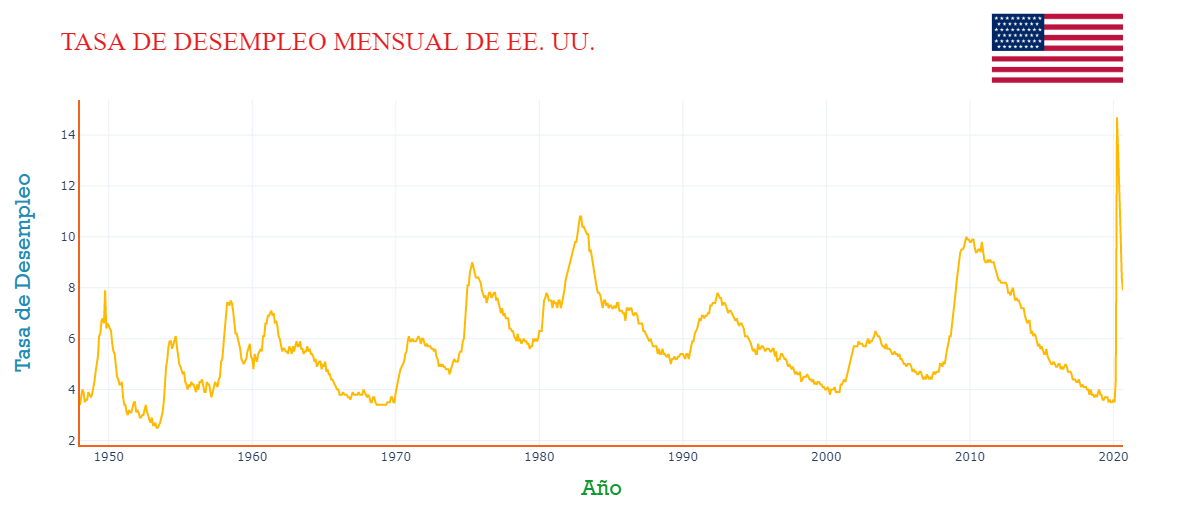

In [4]:
Figura = go.Figure()
Figura.add_scatter(
    x = df.index, y = df["UNRATE"],
    mode = "lines", line =  dict(color = "#FFB900", width = 2),
    name = "Cobertura Neta", showlegend = False
)
Figura.show()

***
___
## **PREPROCESAMIENTO DE LOS DATOS**

### *Escalamiento*

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler  = MinMaxScaler(feature_range = (0, 1))
dataset = pd.DataFrame(scaler.fit_transform(df.values), index = df.index, columns = ["serie"])

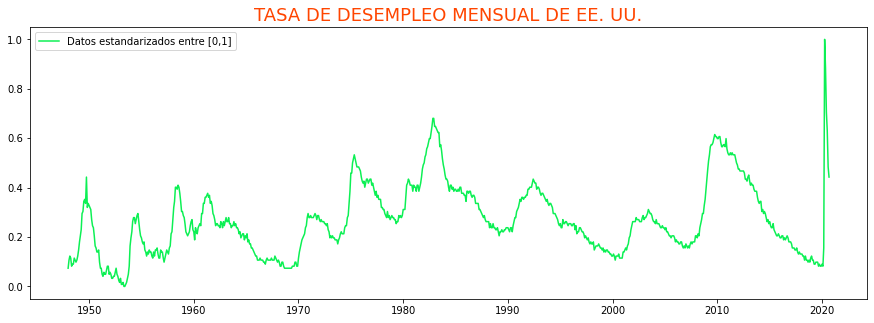

In [6]:
plt.figure(figsize = (15,5))
plt.plot(dataset, color = "#0CF054", label = "Datos estandarizados entre [0,1]")
plt.title("TASA DE DESEMPLEO MENSUAL DE EE. UU.", size = 18, color = "#FF4500")
plt.legend()
plt.show()

### *Partición del Conjunto de Datos (**Split Data**)*

In [7]:
train_size = int(len(dataset) * 0.8)
test_size  = len(dataset) - train_size

train, test = dataset.iloc[0:train_size], dataset.iloc[train_size:len(df)]

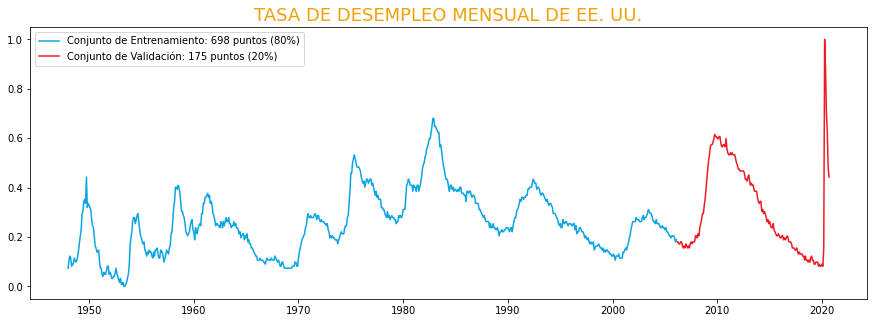

In [8]:
plt.figure(figsize = (15,5))
plt.plot(train, color = "#0BA5E3", label = "Conjunto de Entrenamiento: " + str(len(train)) + " puntos (80%)")
plt.plot(test , color = "#ED1B24", label = "Conjunto de Validación: " + str(len(test)) + " puntos (20%)")
plt.title("TASA DE DESEMPLEO MENSUAL DE EE. UU.", size = 18, color = "#F2A007")
plt.legend()
plt.show()

In [9]:
def create_dataset(X, y, time_steps = 1):
    Xs, ys = [], []
    # El primer lote de datos empieza en la primera observación y toma time_steps datos.
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 50
X_train, y_train = create_dataset(train, train, time_steps)
X_test , y_test  = create_dataset(test , test , time_steps)

print(X_train.shape, y_train.shape)

(648, 50, 1) (648, 1)


***
___
## **CONSTRUCCIÓN DEL MODELO**

Model: "series_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 1)]           0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 60)                14880     
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


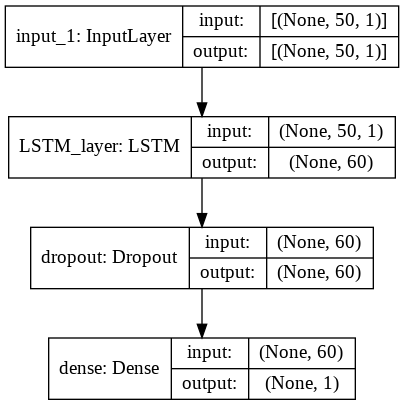

In [11]:
import tensorflow.keras as keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Modelo = Sequential(
#     [
#       LSTM(units = 60, input_shape = (X_train.shape[1], X_train.shape[2])),
#       Dropout(0.1),
#       Dense(1)
#     ]
# )

# # Compilación
# Modelo.compile(loss = "mean_squared_error", optimizer = Adam(0.001))

# # Resumen
# Modelo.summary()

# Tamaños
inputs_shape = (X_train.shape[1], X_train.shape[2])
lstm_output  = 60
# Capas
inputs = Input(inputs_shape)
x = LSTM(units = lstm_output, name = "LSTM_layer")(inputs)
y = Dropout(0.2)(x)
outputs = Dense(1)(y)
# Modelo
Modelo = Model(inputs = inputs, outputs = outputs, name = "series_LSTM_model")
# Compilación
Modelo.compile(loss = "mean_squared_error", optimizer = Adam(0.001))

from tensorflow.keras.utils import plot_model
Modelo.summary()
plot_model(Modelo, show_shapes = True)

In [12]:
# Entrenamiento
Epocas  = 30
History = Modelo.fit(X_train, y_train,
                     epochs = Epocas,
                     batch_size = 16,
                     validation_split = 0.1,
                     verbose = 1,
                     shuffle = False
                     )

Epoch 1/30
37/37 [==============================] - 20s 44ms/step - loss: 0.0125 - val_loss: 8.7765e-04
Epoch 2/30
37/37 [==============================] - 1s 23ms/step - loss: 0.0049 - val_loss: 9.3052e-04
Epoch 3/30
37/37 [==============================] - 1s 23ms/step - loss: 0.0044 - val_loss: 5.5053e-04
Epoch 4/30
37/37 [==============================] - 1s 24ms/step - loss: 0.0042 - val_loss: 4.4710e-04
Epoch 5/30
37/37 [==============================] - 1s 23ms/step - loss: 0.0040 - val_loss: 4.6227e-04
Epoch 6/30
37/37 [==============================] - 1s 24ms/step - loss: 0.0034 - val_loss: 6.7697e-04
Epoch 7/30
37/37 [==============================] - 1s 23ms/step - loss: 0.0031 - val_loss: 4.0227e-04
Epoch 8/30
37/37 [==============================] - 1s 23ms/step - loss: 0.0026 - val_loss: 4.4466e-04
Epoch 9/30
37/37 [==============================] - 1s 24ms/step - loss: 0.0024 - val_loss: 3.0149e-04
Epoch 10/30
37/37 [==============================] - 1s 23ms/step - loss

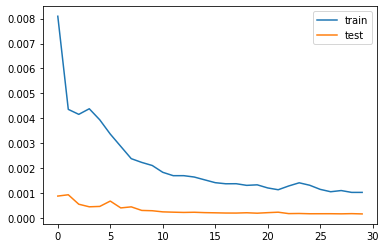

In [13]:
# Evaluación del modelo
plt.plot(History.history['loss']    , label = "train")
plt.plot(History.history["val_loss"], label = "test")
plt.legend()

In [14]:
y_pred = Modelo.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
y_train = scaler.inverse_transform(y_train.reshape(-1,1))

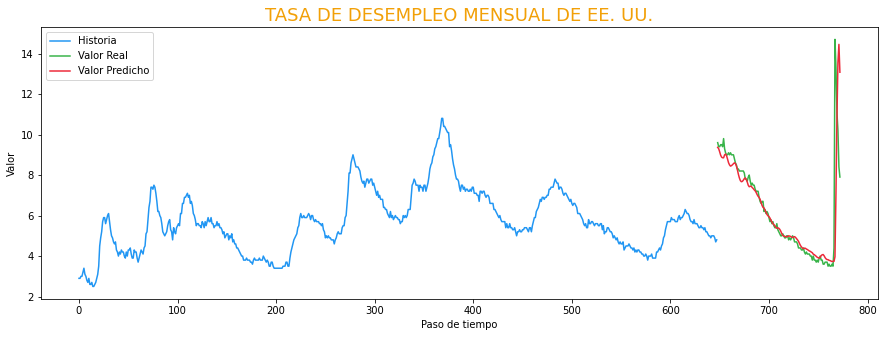

In [15]:
plt.figure(figsize = (15,5))
plt.plot(np.arange(0, len(y_train)), y_train, color = "#2196F3", label = "Historia")
plt.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_test, color = "#38B449", label = "Valor Real")
plt.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_pred, color = "#ED2939", label = "Valor Predicho")
plt.ylabel("Valor"); plt.xlabel("Paso de tiempo")
plt.title("TASA DE DESEMPLEO MENSUAL DE EE. UU.", size = 18, color = "#F2A007")
plt.legend()
plt.show()

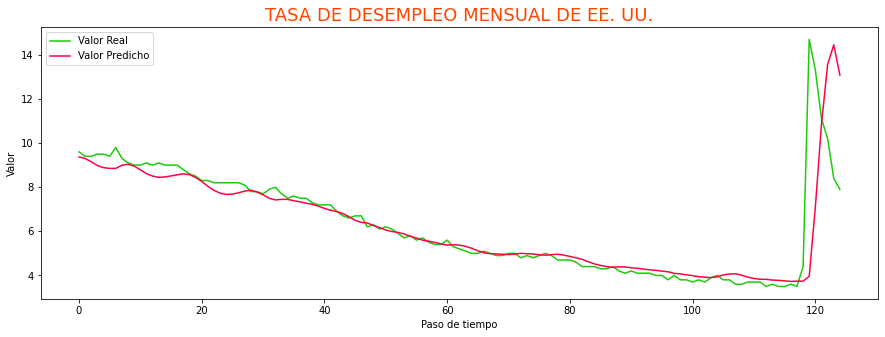

In [16]:
plt.figure(figsize = (15,5))
plt.plot(y_test, color = "#1BCB0A", label = "Valor Real")
plt.plot(y_pred, color = "#FF0045", label = "Valor Predicho")
plt.ylabel("Valor"); plt.xlabel("Paso de tiempo")
plt.title("TASA DE DESEMPLEO MENSUAL DE EE. UU.", size = 18, color = "#FF4500")
plt.legend()
plt.show()

***
___
## **CONFIDENCE INTERVALS [#1](https://medium.com/hal24k-techblog/how-to-generate-neural-network-confidence-intervals-with-keras-e4c0b78ebbdf)**

In [17]:
from keras.models import Model
from keras import backend as K

def create_dropout_predict_function(model, dropout):
    """
    Create a keras function to predict with dropout
    model : keras model
    dropout : fraction dropout to apply to all layers
    
    Returns
    predict_with_dropout : keras function for predicting with dropout
    """
    
    # Load the config of the original model
    conf = model.get_config()
    # Add the specified dropout to all layers
    for layer in conf['layers']:
        # Dropout layers
        if layer["class_name"]=="Dropout":
            layer["config"]["rate"] = dropout
        # Recurrent layers with dropout
        elif "dropout" in layer["config"].keys():
            layer["config"]["dropout"] = dropout

    # Create a new model with specified dropout
    if type(model)==Sequential:
        # Sequential
        model_dropout = Sequential.from_config(conf)
    else:
        # Functional
        model_dropout = Model.from_config(conf)
    model_dropout.set_weights(model.get_weights()) 
    
    # Create a function to predict with the dropout on
    predict_with_dropout = K.function(model_dropout.inputs, model_dropout.outputs)
    
    return predict_with_dropout

In [18]:
dropout = 0.35
num_iter = 100
num_samples = y_train.shape[0]

predict_with_dropout = create_dropout_predict_function(Modelo, dropout)
predictions = np.zeros((num_samples, num_iter))
for i in range(num_iter):
    predictions[:,i] = predict_with_dropout(X_train)[0].reshape(-1)

In [19]:
ci = 0.8
lower_lim = np.quantile(predictions, 0.5-ci/2, axis = 1)
upper_lim = np.quantile(predictions, 0.5+ci/2, axis = 1)

In [20]:
lower_lim = scaler.inverse_transform(lower_lim.reshape(-1,1))
upper_lim = scaler.inverse_transform(upper_lim.reshape(-1,1))
upper_lim.shape

(648, 1)

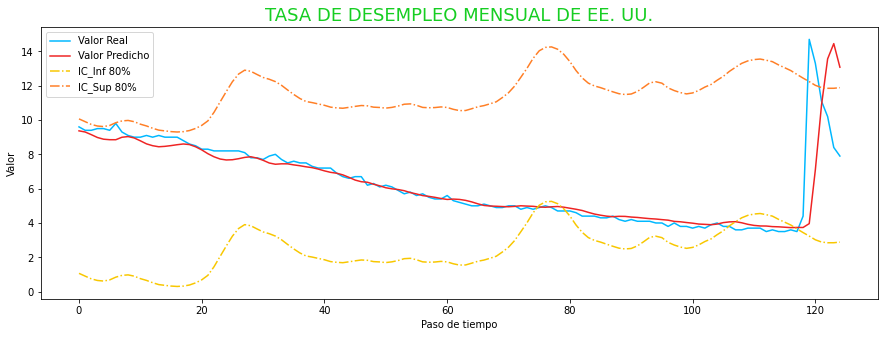

In [21]:
plt.figure(figsize = (15,5))
plt.plot(y_test, color = "#00B8FF", label = "Valor Real")
plt.plot(y_pred, color = "#EE2424", label = "Valor Predicho")
plt.plot(lower_lim[0:y_test.shape[0]], color = "#F8C700", label = "IC_Inf 80%", linestyle = "-.")
plt.plot(upper_lim[0:y_test.shape[0]], color = "#FF7F26", label = "IC_Sup 80%", linestyle = "-.")
plt.ylabel("Valor"); plt.xlabel("Paso de tiempo")
plt.title("TASA DE DESEMPLEO MENSUAL DE EE. UU.", size = 18, color = "#16CE22")
plt.legend()
plt.show()

***
___
## **CONFIDENCE INTERVALS [#2](https://towardsdatascience.com/time-series-forecasting-using-tensorflow-and-deep-hybrid-learning-5088ad76dd55)**

In [22]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/DATA/UNRATE.csv", sep = ";")

In [23]:
# Convirtiendo los valores de los datos en números para un procesamiento mejor y más rápido
time_index = np.array(df["DATE"])
data = np.array(df["UNRATE"])
# Definiendo algunos hiperparámetros
SPLIT_RATIO = 0.8
WINDOW_SIZE = 24
BATCH_SIZE  = 16
SHUFFLE_BUFFER = 100
# División del conjunto de prueba y entrenamiento
split_index = int(SPLIT_RATIO * data.shape[0])
# Train-Test Split
train_data = data[:split_index]
train_time = time_index[:split_index]
test_data  = data[split_index:]
test_time  = time_index[split_index:]

In [24]:
import tensorflow as tf
def ts_data_generator(data, window_size, batch_size, shuffle_buffer):
  '''
  Utility function for time series data generation in batches
  '''
  ts_data = tf.data.Dataset.from_tensor_slices(data)
  ts_data = ts_data.window(window_size+1, shift = 1, drop_remainder = True)
  ts_data = ts_data.flat_map(lambda window: window.batch(window_size+1))
  ts_data = ts_data.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  ts_data = ts_data.batch(batch_size).prefetch(1)
  return ts_data
# Expandiendo datos en tensores
tensor_train_data = tf.expand_dims(train_data, axis = -1)
tensor_test_data  = tf.expand_dims(test_data , axis = -1)

tensor_train_dataset = ts_data_generator(tensor_train_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
tensor_test_dataset  = ts_data_generator(tensor_test_data , WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)

In [25]:
Modelo = Sequential(
    [
      LSTM(units = 64, input_shape = [None, 1]),
      Dropout(0.1),
      Dense(1)
    ]
)

# Compilación
Modelo.compile(loss = "mean_squared_error", optimizer = Adam(0.001), metrics = "mean_squared_error")

In [26]:
History = Modelo.fit(tensor_train_dataset, epochs = Epocas, validation_data = tensor_test_dataset, verbose = 0)

In [27]:
def model_forecast(model, data, window_size):
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window_size, shift=1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(16).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(Modelo, data[..., np.newaxis], WINDOW_SIZE)
rnn_forecast = rnn_forecast[split_index - WINDOW_SIZE:-1, -1]

# Overall Error
from keras.metrics import mean_absolute_error
error = mean_absolute_error(test_data, rnn_forecast).numpy()

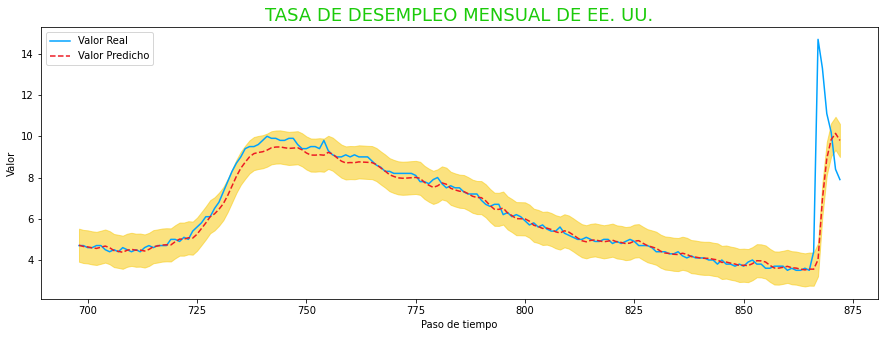

In [28]:
plt.figure(figsize = (15,5))
plt.plot(list(range(split_index,len(data))), test_data, color = "#00A3FF", label = "Valor Real")
plt.plot(list(range(split_index,len(data))), rnn_forecast, color = "#ED1B24", linestyle = '--', label = "Valor Predicho")
plt.fill_between(range(split_index,len(data)), rnn_forecast-error, rnn_forecast+error, color = "#F8C700", alpha = 0.5)
plt.ylabel("Valor"); plt.xlabel("Paso de tiempo")
plt.title("TASA DE DESEMPLEO MENSUAL DE EE. UU.", size = 18, color = "#1BCB0A")
plt.legend()
plt.show()